In [11]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# AirBnB Bookings 
### Predicting first destinations of new users
****

# Introduction
****

## The Client

>Airbnb is a website for people to list, find, and rent lodging. It has over 1,500,000 listings in 34,000 cities and 190 countries. Founded in August 2008 and headquartered in San Francisco, California, the company is privately owned and operated by Airbnb, Inc. - [AirBnB Wikipedia Page](https://en.wikipedia.org/wiki/Airbnb)

## Problem


>New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand. - [AirBnB Kaggle Challenge](kaggle.com/c/airbnb-recruiting-new-user-bookings/)

In this recruiting competition, Airbnb challenged through Kaggle its users to predict in which country a new user will make his or her first booking.

## The data

Firstly, it should be mentioned that the dataset consists only of US users.

There are 12 possible outcomes of the destination country: **'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF'** (no destination found), and **'other'**. 

'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

## The Files
**train_users.csv** - the training set of users

**test_users.csv** - the test set of users

* *id*: user id

* *date_account_created*: the date of account creation

* *timestamp_first_active*: timestamp of the first activity, note that it can be earlier than date_account_created or 
date_first_booking because a user can search before signing up

* *date_first_booking*: date of first booking

* *gender*

* *age*

* *signup_method*

* *signup_flow*: the page a user came to signup up from

* *language*: international language preference

* *affiliate_channel*: what kind of paid marketing

* *affiliate_provider*: where the marketing is e.g. google, craigslist, other

* *first_affiliate_tracked*: whats the first marketing the user interacted with before the signing up

* *signup_app*

* *first_device_type*

* *first_browser*

* *country_destination*: this is the target variable


**sessions.csv** - web sessions log for users

* *user_id*: to be joined with the column 'id' in users table

* *action*

* *action_type*

* *action_detail*

* *device_type*

* *secs_elapsed*


**countries.csv** - summary statistics of destination countries in this dataset and their locations

**age_gender_bkts.csv** - summary statistics of users' age group, gender, country of destination

**sample_submission.csv** - correct format for submitting your predictions

# Approach
****


Before we even start thinking about which classifier to chose and fitting the data into the model  we have to go through a series of steps, in order to have an expected output.

A couple of questions to ask: 
* Is there any missing data we might be dealing with? 
* Are there any unusable formats? 
* Do we have any categorical data? If so, those variables might need encoding
* If we have too many features or if we have a high variance, we might want to consider dimensionality reduction. This means, using any algorithm preferred for choosing a smaller number of features. This can bring benefits from a computation point of view, but also to avoid overfitting, in case there are some variables that just cause noise.


So here are some steps to be taken before choosing an estimator:
* Data Cleaning
* Encoding categorial data
* Handeling dates for encoding
* Standardizing/Normalizing data
* Dimensionality Reduction - *optional*
* Cross Validating
* Feature Importance


## Data Cleaning 
****

### Missing Values

A quick view of how much data we're actually missing can be useful to understand which features we can trust when the time of feature selecting comes in. 

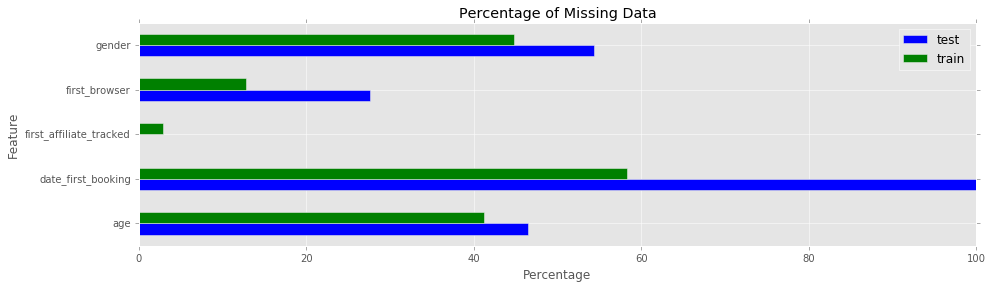

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,4)


#reading data
train_data = pd.read_csv('data/train_users_2.csv')
train_nan = train_data.replace('-unknown-', np.nan)
test_data = pd.read_csv('data/test_users.csv')
test_nan = test_data.replace('-unknown-',np.nan)

total_row_train = float(train_nan.shape[0])
total_row_test = float(test_nan.shape[0])

x = {}
for item in list(train_nan.columns):
    x[item] = {}
    x[item]['train'] = float(train_nan[train_nan[item].isnull()].shape[0])/total_row_train * 100
    
for item in list(test_nan.columns):
    x[item]['test'] = float(test_nan[test_nan[item].isnull()].shape[0])/total_row_test * 100

z = pd.DataFrame(x).fillna(0).T
z[(z.train >0) & (z.test >0)].plot(kind = 'barh')
pl.title("Percentage of Missing Data")
pl.ylabel("Feature")
pl.xlabel("Percentage");

The immediate thing we realise is the fact that date_first_booking will be completely missing from the test set. This makes sense, since the users have not made their first booking at this point, and no country is being predicted for them. But this is definitely a feature that we shouldn't use when we're fitting the model.

## Age

#### Training Data

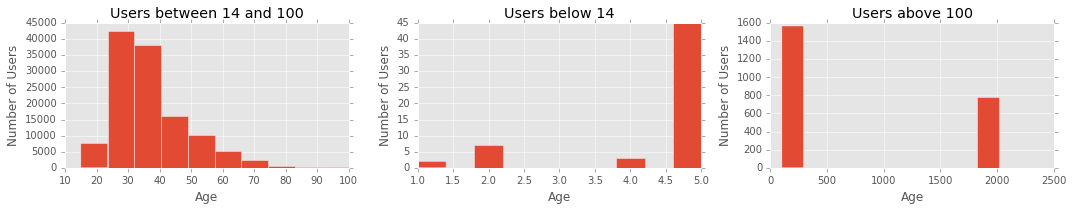

In [60]:
plt.rcParams['figure.figsize'] = (15,3)
pl.subplot(1,3,1)
train_data[(train_data.age >= 14) & (train_data.age <= 100)]['age'].hist()
pl.title('Users between 14 and 100')
pl.xlabel("Age")
pl.ylabel("Number of Users")

pl.subplot(1,3,2)
train_data[train_data.age < 14]['age'].hist()
pl.title('Users below 14')
pl.xlabel("Age")
pl.ylabel("Number of Users")

pl.subplot(1,3,3)
train_data[train_data.age > 100]['age'].hist()
pl.title('Users above 100')
pl.xlabel("Age")
pl.ylabel("Number of Users")
plt.tight_layout();

#### Test Data

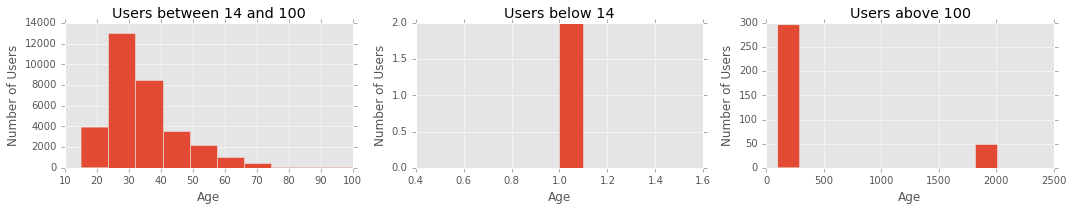

In [14]:
plt.rcParams['figure.figsize'] = (15,3)
pl.subplot(1,3,1)
test_data[(test_data.age >= 14) & (test_data.age <= 100)]['age'].hist()
pl.title('Users between 14 and 100')
pl.xlabel("Age")
pl.ylabel("Number of Users")

pl.subplot(1,3,2)
test_data[test_data.age < 14]['age'].hist()
pl.title('Users below 14')
pl.xlabel("Age")
pl.ylabel("Number of Users")

pl.subplot(1,3,3)
test_data[test_data.age > 100]['age'].hist()
pl.title('Users above 100')
pl.xlabel("Age")
pl.ylabel("Number of Users")
plt.tight_layout();

The general majority of users got their age input correctly, but some of them, in both training and test set entered either an incorrect age, either their birth year, or current year.
This can be misleading when training on it, since the scaling phase of the project on of this variable might not reflect the reality.

One way of working with this is to replace values which would represent outliers, with a value that would make the classifier understand it's an incorrect value. In this case, replacing it with "-1" might do a bit of justice to the data.

## Country Destination

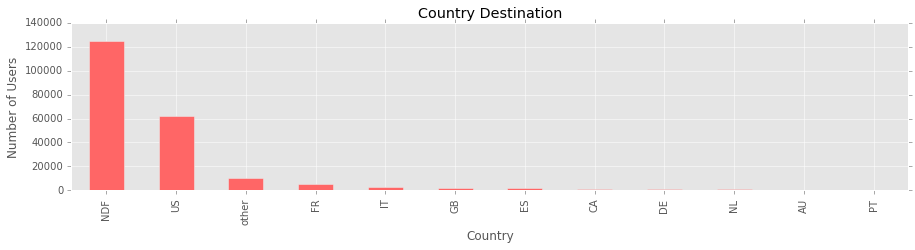

In [15]:
train_data.country_destination.value_counts().plot(kind = 'bar',color = '#ff6666')
pl.title("Country Destination")
pl.xlabel("Country")
pl.ylabel("Number of Users");

The main learning we take out of this graph is the fact that we have are dealing with an ***imbalanced dataset***: A very significant amount of users in the training set didn't chose any destination, and this might cause difficulty in choosing accurate predictions for the test set.

There is nothing we can do in this state to fix this issue, instead be aware that accuracy score of the Cross Validation phase is not the best metric to look at. Instead, choosing to look into Precission Score, Recall score and F1 score can reflect the prediction better.

## Encoding categorical data
****

Most of the classifiers which exist at the moment can't handle categorical data automatically. This means that we would need to encode them ourselves. Examples of categorical features in this case would be: **gender, language, first_device_type.**

In this case we used **LabelEncoder()** module as part of the **preprocessing** package sklearn offers.

## Encoding Dates
****

Dates are a particular case where they are half categorical, half numerical. You can't use them at their current state, but you can take parts of it and consider that numerical. As a result, we will have at least 3-4 extra features we can gather from dates. The dates columns will be split into: 
* year
* month
* day
* day of week

## Encoding Labels
****

Since this situation shows us 12 different classes for the labels, these as well need to be encoded in a format that the models can read it. Pandas offers an option of getting the dummy variables for labels, but I chose to stick with a combination of both:
* *pandas.get_dummies()* - for remembering the column names
* *LabelBinarizer()* - for actually encoding the labels

## Standardizing/Normalizing Data
****

**MinMaxScaler()**

>Transforms features by scaling each feature to a given range.
This estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one.
The transformation is given by:

$$X_{std} = \frac{X - X.min}{X.max - X.min}$$



>where min, max = feature_range.
This transformation is often used as an alternative to zero mean, unit variance scaling. - [Sklearn Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

## Chosen estimator

*Multiclass Problem*

We should take into account that  we're dealing with a Multiclass problem, so we will have to use a multiclass clasiffier. **OneVsRest** will be used for comparing each class with the rest of them.

Now that we've got everything in place, we can finally choose what estimator to start with. In this case, we went with **Random forests.**

The reasoning for this was that:
* it's simply one of the [most common classifiers](http://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/) to be used for labeled data
* can deal well with a large amount of data
* figures out for itself which features are more important
* can create complex models without overfitting

## Cross Validating


One very important part of understanding how your chosen estimator is doing, is by cross validation.
The concept is simple: 
* split your training data into an acceptable size on each - generally would go for a 70-30 split
* run the entire process on your new training data
* predicting on your newly split test data
* test to see if your predicted labels match the solution.

With this data and this estimator, we got a **89% accuracy score**, and a **92% F1 - score**. 


## Feature Importances

Random Forests have a very nice method built in, where we can understand which features have a higher importance in every iteration, and where we should be careful to get as clean data as possible.

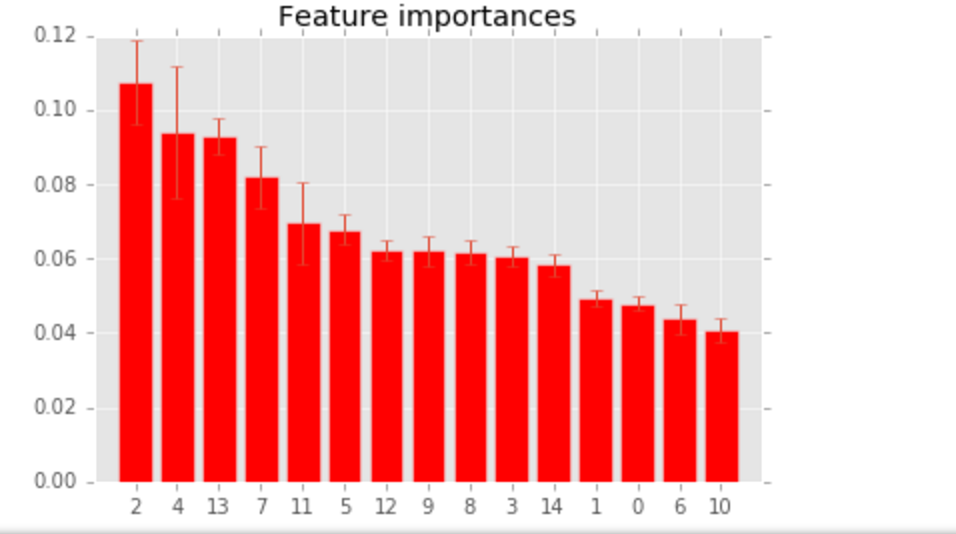

In [16]:
from IPython.display import Image
Image(filename='/Users/mirunapopa/Desktop/Screen Shot 2016-02-28 at 17.29.37.png', width = 500, height = 200) 

The first four of this particular graph have been the ones which appeared in the majority of the cases. They represent: 
    
* **2 - 'signup_method'**
* **4 - 'language'**
* **13 - 'action_detail'**
* **7 - 'first_affiliate_tracked'**

Let's have a closer look into a couple of them. In the following graphs, red will represent the "Train data", while green will be the "test data": 

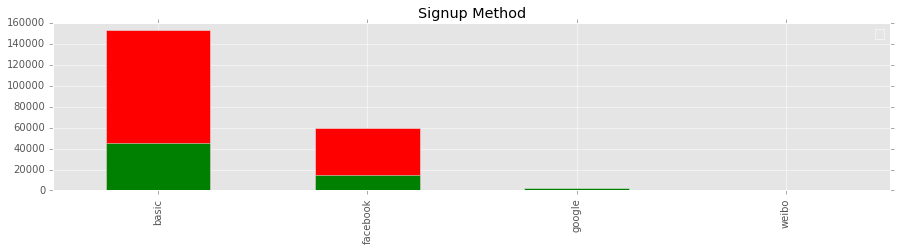

In [73]:
items = ['signup_method', 'language', 'first_affiliate_tracked']

plt.subplot(1,1,1)
train = train_data[items[0]].value_counts().plot(kind = 'bar',color = 'red', label = 'train')
test = test_data[items[0]].value_counts().plot(kind = 'bar',color = 'green', label = 'test')
pl.legend(handles = [train,test])
pl.title("Signup Method");

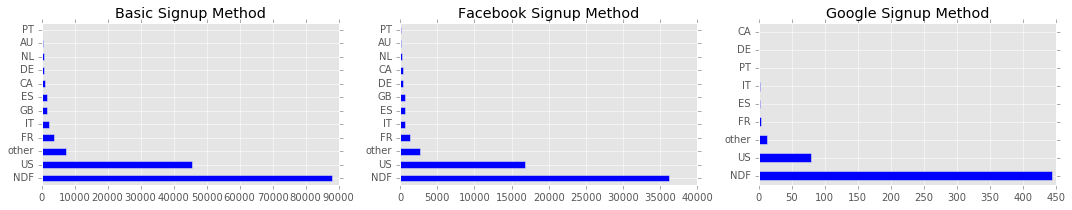

In [74]:
plt.subplot(1,3,1)
train_data[train_data.signup_method == 'basic']["country_destination"].value_counts().plot(kind ='barh')
pl.title("Basic Signup Method")
plt.subplot(1,3,2)
train_data[train_data.signup_method == 'facebook']["country_destination"].value_counts().plot(kind ='barh')
pl.title("Facebook Signup Method")
plt.subplot(1,3,3)
train_data[train_data.signup_method == 'google']["country_destination"].value_counts().plot(kind ='barh')
pl.title("Google Signup Method")
plt.tight_layout();

These graphs tell us a number of things, on which the model is focusing on: 

* most of the people sign up through the basic signup method - they come here for a specific reason.
* fewer users came through facebook, but this gives a good hint where to invest our next marketing campaign budged - facebook works beter than google
* people which signed up through google, seemed to also convert, but in a low amount - maybe if the budged allows, that also makes sense looking into
    

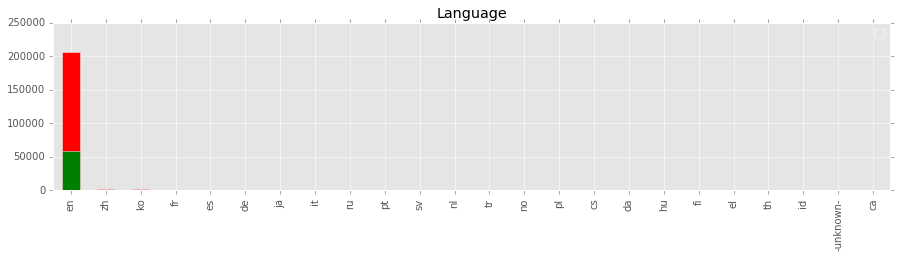

In [75]:
plt.subplot(1,1,1)
train = train_data[items[1]].value_counts().plot(kind = 'bar',color = 'red', label = 'train')
test = test_data[items[1]].value_counts().plot(kind = 'bar',color = 'green', label = 'test')
pl.legend(handles = [train,test])
pl.title("Language");

The language can give a good idea about where are these US users from: 
* have they moved here with work and now are flying back home to meet their loved ones? 
* should we communicate differently to them? 

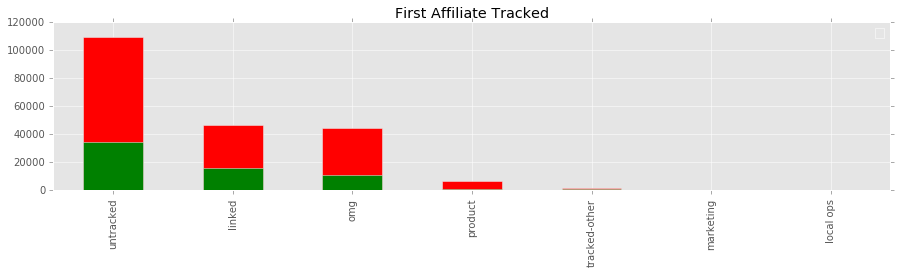

In [46]:
items = ['signup_method', 'language', 'first_affiliate_tracked']

plt.subplot(1,1,1)
train = train_data[items[2]].value_counts().plot(kind = 'bar',color = 'red', label = 'train')
test = test_data[items[2]].value_counts().plot(kind = 'bar',color = 'green', label = 'test')
pl.legend(handles = [train,test])
pl.title("First Affiliate Tracked");

It's a bit concerning that most of the users aren't really tracked initially. This can cause the model to put too generalize on the users which weren't even tracked to begin with. This should be handled better in the future.

## Future Approaches

The current approach was to merge the files of the training set with sessions. This resulted in a dataset with multiple rows for each user, and averaging the final probabilities at the end.

A different approach would be to first average the sessions behaviour, and then merge with the dataset. This could improve speed of the classifier, as well as results. 

# Conclusions / Recommendations

1). **Better data collection of age** 

Seems to be an important determinant in predicting the first destination of a user, maybe a different aproach in collecting this data would make more sense:
    * asking for the date of birth

2). **More and richer data**

More features might be helpful in determining a first possible location. Relying only on details about a user and their sessions might make this data biased, and will only fit on users which meet the same variables as these do. 

3). **Fixing the imbalanced dataset issue**

The model at this point will focus a lot on users which haven't done a booking, and that can reflect on the results: meaning that many of the new users will have a high probability of not booking something. 

4). **Better tracking in place** 

The model might focus too much on the users which weren't tracked to begin with, so it's very important that we have these details in place

For further technical details about the approach, details can he found in this notebook:

https://github.com/mirunapopa/DS-Intensive/blob/master/data-science-project_random_forests.ipynb

# Thank you!